In [1]:
#---This program is used to forecast 1 week CDRs based on 55 previous days' data

#---Install these bibs so the program works properly
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from numpy import loadtxt
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
#--Loading Cell_ID vector, whose elements tell from which ID the matrix_TS row is the corresponding time-series

Cell_ID = loadtxt('ID_labels.csv', delimiter=',') 
df = pd.read_csv('matrixTS.csv',header=None)
df.head(6)


,0,1,2,3,4,5,6,7,8,9,...,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487
0,13,11,8,7,8,9,11,12,13,18,...,23.0,17.0,20.0,16.0,16.0,18.0,19.0,21.0,17.0,13.0
1,13,11,10,7,6,9,11,11,13,17,...,22.0,15.0,20.0,15.0,15.0,18.0,20.0,19.0,17.0,13.0
2,15,11,9,11,9,8,12,18,23,31,...,6.0,9.0,9.0,11.0,8.0,7.0,7.0,8.0,7.0,5.0
3,12,11,7,9,6,6,8,15,12,23,...,14.0,12.0,17.0,17.0,15.0,14.0,12.0,13.0,14.0,10.0
4,10,8,11,7,8,8,12,16,16,16,...,28.0,26.0,23.0,26.0,27.0,19.0,18.0,20.0,14.0,18.0
5,11,8,7,6,8,8,6,7,12,14,...,14.0,13.0,12.0,14.0,14.0,12.0,12.0,16.0,11.0,10.0


In [3]:
#--Defines the Cell ID to be forecasted, size of training data

days = 62 #Train and validation sizes need to be changed if this value is tunned
matrix = df.to_numpy()

#-- This part is to get the cell ID time-series of IDs that surround 1051 [1050, 1052, 1150, 1151, 1152]
ID_1051=60
cells = [1050, 1052, 1150, 1151, 1152]
pos = []

for item in cells:
    for i in range (0,len(Cell_ID)):
        if item == Cell_ID[i]:
            pos.append(i)
            break
print('1050, 1052, 1150, 1151, 1152:',Cell_ID[pos[0]], Cell_ID[pos[1]], Cell_ID[pos[2]], Cell_ID[pos[3]], Cell_ID[pos[4]])

TS_950 = np.array(loadtxt('CellID950.csv', delimiter=','))
TS_951 = np.array(loadtxt('CellID951.csv', delimiter=','))
TS_952 = np.array(loadtxt('CellID952.csv', delimiter=','))

TS_1050 = matrix[pos[0]][:]
TS_1051 = matrix[ID_1051][:] #-This is the one to predict
TS_1052 = matrix[pos[1]][:]
TS_1150 = matrix[pos[2]][:]
TS_1151 = matrix[pos[3]][:]
TS_1152 = matrix[pos[4]][:]

#--Spliting the data set into Training/Validating/Testing
#--Standardizing the time-series
train_size = 24*50 
validation_size = 24*5

mean_TS_950 = TS_950[:train_size].mean() #--Considering just the training part
std_TS_950 = TS_950[:train_size].std() #--Considering just the training part

mean_TS_951 = TS_951[:train_size].mean() #--Considering just the training part
std_TS_951 = TS_951[:train_size].std() #--Considering just the training part

mean_TS_952 = TS_952[:train_size].mean() #--Considering just the training part
std_TS_952 = TS_952[:train_size].std() #--Considering just the training part

mean_TS_1050 = TS_1050[:train_size].mean() #--Considering just the training part
std_TS_1050 = TS_1050[:train_size].std() #--Considering just the training part

mean_TS_1051 = TS_1051[:train_size].mean() #--Considering just the training part
std_TS_1051 = TS_1051[:train_size].std() #--Considering just the training part

mean_TS_1052 = TS_1052[:train_size].mean() #--Considering just the training part
std_TS_1052 = TS_1052[:train_size].std() #--Considering just the training part

mean_TS_1150 = TS_1150[:train_size].mean() #--Considering just the training part
std_TS_1150 = TS_1150[:train_size].std() #--Considering just the training part

mean_TS_1151 = TS_1151[:train_size].mean() #--Considering just the training part
std_TS_1151 = TS_1151[:train_size].std() #--Considering just the training part

mean_TS_1152 = TS_1152[:train_size].mean() #--Considering just the training part
std_TS_1152 = TS_1152[:train_size].std() #--Considering just the training part


Norm_TS_950 = (TS_950 - mean_TS_950) / std_TS_950
Norm_TS_951 = (TS_951 - mean_TS_951) / std_TS_951
Norm_TS_952 = (TS_952 - mean_TS_952) / std_TS_952

Norm_TS_1050 = (TS_1050 - mean_TS_1050) / std_TS_1050
Norm_TS_1051 = (TS_1051 - mean_TS_1051) / std_TS_1051
Norm_TS_1052 = (TS_1052 - mean_TS_1052) / std_TS_1052

Norm_TS_1150 = (TS_1150 - mean_TS_1150) / std_TS_1150
Norm_TS_1151 = (TS_1151 - mean_TS_1151) / std_TS_1151
Norm_TS_1152 = (TS_1152 - mean_TS_1152) / std_TS_1152

1050, 1052, 1150, 1151, 1152: 1050.0 1052.0 1150.0 1151.0 1152.0


Text(0, 0.5, 'CDR')

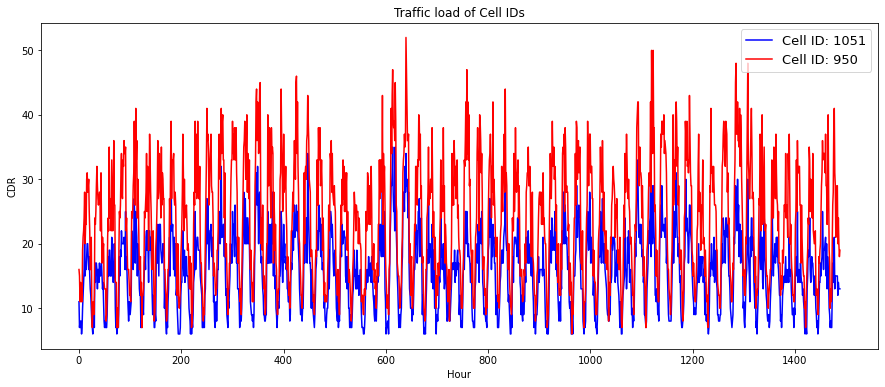

In [4]:
#---Plot of the Cell ID CDR
hour = np.linspace(0,24*days,24*days)

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell IDs') 
plt.plot(hour,TS_1051,'b',label="Cell ID: %d" % (Cell_ID[ID_1051]))
plt.plot(hour,TS_950,'r',label="Cell ID: 950")
plt.legend(loc='upper right',fontsize=13)
plt.xlabel("Hour")
plt.ylabel("CDR")

## Constructing the 3D tensor and respectives Outputs

In [5]:
tensor = []

for i in range(0,len(TS_950)):
    tensor.append([[Norm_TS_1150[i], Norm_TS_1151[i], Norm_TS_1152[i]], 
                        [Norm_TS_1050[i], Norm_TS_1051[i], Norm_TS_1052[i]],
                        [Norm_TS_950[i], Norm_TS_951[i], Norm_TS_952[i]]])


In [6]:
#---This function creates the sliding window to construct the training data set. 

def df_to_X_y(df,window_size):
    df_as_np = df
    X = []
    y = []
    for i in range(len(tensor)-window_size):
        row = [a for a in df_as_np[i:i+window_size]] 
        X.append(row)
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)

#-X contains 1464 tensors with 24 matrices (24 hours) of dimension 3x3 (IDs surrounding ID 1051- see Figure in the Survey Paper)
#-y contains 1464 matrices of dimension 3x3 used in the training

In [7]:
WINDOW_SIZE = 24
X,y = df_to_X_y(tensor,WINDOW_SIZE)
print('Initial Shape', X.shape, y.shape)

y_flatten = []
for item in y:
    y_flatten.append(item.flatten())

y_flatten = np.array(y_flatten)
print('Final Shape', X.shape, y.shape)

Initial Shape (1464, 24, 3, 3) (1464, 3, 3)
Final Shape (1464, 24, 3, 3) (1464, 3, 3)


In [8]:
#---Reshape tensor X
X = tf.expand_dims(X,axis=4)

## Splitting data to training and testing

In [9]:
X_train, y_train = X[:train_size], y_flatten[:train_size]
X_val, y_val = X[train_size:(train_size+validation_size)], y_flatten[train_size:(train_size+validation_size)]

X_train.shape, X_val.shape

(TensorShape([1200, 24, 3, 3, 1]), TensorShape([120, 24, 3, 3, 1]))

## Constructing Simple CNN model

In [10]:
X_train[0].shape

TensorShape([24, 3, 3, 1])

In [11]:
model1 = Sequential()

#-Comment or uncomment lines to insert/remove layers of the CNN
#-Change the number of neurons inside each layers

d=1 # Kernel size in time-dimension
model1.add(layers.Conv3D(32, (d, 2, 2), activation='relu', padding='same', input_shape=(24, 3, 3, 1)))
model1.add(layers.AveragePooling3D((2, 2, 2),padding='same'))

model1.add(layers.Conv3D(32, (d, 2, 2), activation='relu',padding='valid'))
model1.add(layers.AveragePooling3D((2, 1, 1),padding='valid'))

model1.add(layers.Flatten())
model1.add(Dense(32,'relu'))
model1.add(Dense(9,'linear'))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 24, 3, 3, 32)      160       
_________________________________________________________________
average_pooling3d (AveragePo (None, 12, 2, 2, 32)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 1, 1, 32)      4128      
_________________________________________________________________
average_pooling3d_1 (Average (None, 6, 1, 1, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6176      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 2

In [12]:
#--Model Training

#-Set the hyperparemeters according to your application: learning_rate, epochs, batch size
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=1000, batch_size=32)

Train on 1200 samples, validate on 120 samples
Epoch 1/1000
1200/1200 [==============================] - 1s 496us/sample - loss: 0.9986 - root_mean_squared_error: 0.9993 - val_loss: 1.0428 - val_root_mean_squared_error: 1.0212
Epoch 2/1000
1200/1200 [==============================] - 0s 193us/sample - loss: 0.9439 - root_mean_squared_error: 0.9715 - val_loss: 0.9991 - val_root_mean_squared_error: 0.9995
Epoch 3/1000
1200/1200 [==============================] - 0s 201us/sample - loss: 0.8821 - root_mean_squared_error: 0.9392 - val_loss: 0.9383 - val_root_mean_squared_error: 0.9687
Epoch 4/1000
1200/1200 [==============================] - 0s 190us/sample - loss: 0.7943 - root_mean_squared_error: 0.8912 - val_loss: 0.8483 - val_root_mean_squared_error: 0.9211
Epoch 5/1000
1200/1200 [==============================] - 0s 199us/sample - loss: 0.6758 - root_mean_squared_error: 0.8221 - val_loss: 0.7354 - val_root_mean_squared_error: 0.8576
Epoch 6/1000
1200/1200 [=============================

1200/1200 [==============================] - 0s 195us/sample - loss: 0.2116 - root_mean_squared_error: 0.4600 - val_loss: 0.3077 - val_root_mean_squared_error: 0.5547
Epoch 47/1000
1200/1200 [==============================] - 0s 187us/sample - loss: 0.2114 - root_mean_squared_error: 0.4597 - val_loss: 0.3091 - val_root_mean_squared_error: 0.5559
Epoch 48/1000
1200/1200 [==============================] - 0s 193us/sample - loss: 0.2110 - root_mean_squared_error: 0.4593 - val_loss: 0.3064 - val_root_mean_squared_error: 0.5535
Epoch 49/1000
1200/1200 [==============================] - 0s 190us/sample - loss: 0.2109 - root_mean_squared_error: 0.4592 - val_loss: 0.3076 - val_root_mean_squared_error: 0.5547
Epoch 50/1000
1200/1200 [==============================] - 0s 191us/sample - loss: 0.2104 - root_mean_squared_error: 0.4587 - val_loss: 0.3068 - val_root_mean_squared_error: 0.5539
Epoch 51/1000
1200/1200 [==============================] - 0s 191us/sample - loss: 0.2102 - root_mean_squared

1200/1200 [==============================] - 0s 156us/sample - loss: 0.2014 - root_mean_squared_error: 0.4487 - val_loss: 0.3033 - val_root_mean_squared_error: 0.5507
Epoch 92/1000
1200/1200 [==============================] - 0s 155us/sample - loss: 0.2012 - root_mean_squared_error: 0.4486 - val_loss: 0.3076 - val_root_mean_squared_error: 0.5546
Epoch 93/1000
1200/1200 [==============================] - 0s 154us/sample - loss: 0.2017 - root_mean_squared_error: 0.4491 - val_loss: 0.3052 - val_root_mean_squared_error: 0.5525
Epoch 94/1000
1200/1200 [==============================] - 0s 155us/sample - loss: 0.2013 - root_mean_squared_error: 0.4486 - val_loss: 0.3036 - val_root_mean_squared_error: 0.5510
Epoch 95/1000
1200/1200 [==============================] - 0s 154us/sample - loss: 0.2012 - root_mean_squared_error: 0.4486 - val_loss: 0.3040 - val_root_mean_squared_error: 0.5514
Epoch 96/1000
1200/1200 [==============================] - 0s 155us/sample - loss: 0.2008 - root_mean_squared

1200/1200 [==============================] - 0s 165us/sample - loss: 0.1972 - root_mean_squared_error: 0.4441 - val_loss: 0.3047 - val_root_mean_squared_error: 0.5520
Epoch 137/1000
1200/1200 [==============================] - 0s 164us/sample - loss: 0.1973 - root_mean_squared_error: 0.4442 - val_loss: 0.3034 - val_root_mean_squared_error: 0.5508
Epoch 138/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1973 - root_mean_squared_error: 0.4442 - val_loss: 0.3031 - val_root_mean_squared_error: 0.5506
Epoch 139/1000
1200/1200 [==============================] - 0s 166us/sample - loss: 0.1968 - root_mean_squared_error: 0.4436 - val_loss: 0.3024 - val_root_mean_squared_error: 0.5499
Epoch 140/1000
1200/1200 [==============================] - 0s 166us/sample - loss: 0.1967 - root_mean_squared_error: 0.4435 - val_loss: 0.3040 - val_root_mean_squared_error: 0.5513
Epoch 141/1000
1200/1200 [==============================] - 0s 167us/sample - loss: 0.1970 - root_mean_sq

1200/1200 [==============================] - 0s 165us/sample - loss: 0.1938 - root_mean_squared_error: 0.4402 - val_loss: 0.3020 - val_root_mean_squared_error: 0.5496
Epoch 182/1000
1200/1200 [==============================] - 0s 166us/sample - loss: 0.1938 - root_mean_squared_error: 0.4402 - val_loss: 0.3015 - val_root_mean_squared_error: 0.5491
Epoch 183/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1940 - root_mean_squared_error: 0.4404 - val_loss: 0.3025 - val_root_mean_squared_error: 0.5500
Epoch 184/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1938 - root_mean_squared_error: 0.4402 - val_loss: 0.3012 - val_root_mean_squared_error: 0.5488
Epoch 185/1000
1200/1200 [==============================] - 0s 163us/sample - loss: 0.1940 - root_mean_squared_error: 0.4405 - val_loss: 0.3026 - val_root_mean_squared_error: 0.5501
Epoch 186/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1938 - root_mean_sq

1200/1200 [==============================] - 0s 154us/sample - loss: 0.1912 - root_mean_squared_error: 0.4373 - val_loss: 0.2987 - val_root_mean_squared_error: 0.5465
Epoch 227/1000
1200/1200 [==============================] - 0s 163us/sample - loss: 0.1913 - root_mean_squared_error: 0.4373 - val_loss: 0.2973 - val_root_mean_squared_error: 0.5453
Epoch 228/1000
1200/1200 [==============================] - 0s 156us/sample - loss: 0.1916 - root_mean_squared_error: 0.4377 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 229/1000
1200/1200 [==============================] - 0s 155us/sample - loss: 0.1912 - root_mean_squared_error: 0.4373 - val_loss: 0.3015 - val_root_mean_squared_error: 0.5491
Epoch 230/1000
1200/1200 [==============================] - 0s 155us/sample - loss: 0.1912 - root_mean_squared_error: 0.4373 - val_loss: 0.3004 - val_root_mean_squared_error: 0.5481
Epoch 231/1000
1200/1200 [==============================] - 0s 161us/sample - loss: 0.1908 - root_mean_sq

1200/1200 [==============================] - 0s 165us/sample - loss: 0.1894 - root_mean_squared_error: 0.4352 - val_loss: 0.2959 - val_root_mean_squared_error: 0.5439
Epoch 272/1000
1200/1200 [==============================] - 0s 163us/sample - loss: 0.1891 - root_mean_squared_error: 0.4348 - val_loss: 0.2952 - val_root_mean_squared_error: 0.5433
Epoch 273/1000
1200/1200 [==============================] - 0s 163us/sample - loss: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 0.2976 - val_root_mean_squared_error: 0.5455
Epoch 274/1000
1200/1200 [==============================] - 0s 163us/sample - loss: 0.1897 - root_mean_squared_error: 0.4356 - val_loss: 0.2986 - val_root_mean_squared_error: 0.5464
Epoch 275/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1892 - root_mean_squared_error: 0.4350 - val_loss: 0.2964 - val_root_mean_squared_error: 0.5444
Epoch 276/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1899 - root_mean_sq

1200/1200 [==============================] - 0s 174us/sample - loss: 0.1874 - root_mean_squared_error: 0.4329 - val_loss: 0.2946 - val_root_mean_squared_error: 0.5428
Epoch 317/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1871 - root_mean_squared_error: 0.4325 - val_loss: 0.2940 - val_root_mean_squared_error: 0.5423
Epoch 318/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1877 - root_mean_squared_error: 0.4333 - val_loss: 0.2911 - val_root_mean_squared_error: 0.5395
Epoch 319/1000
1200/1200 [==============================] - 0s 166us/sample - loss: 0.1869 - root_mean_squared_error: 0.4323 - val_loss: 0.2946 - val_root_mean_squared_error: 0.5427
Epoch 320/1000
1200/1200 [==============================] - 0s 173us/sample - loss: 0.1871 - root_mean_squared_error: 0.4326 - val_loss: 0.2958 - val_root_mean_squared_error: 0.5439
Epoch 321/1000
1200/1200 [==============================] - 0s 161us/sample - loss: 0.1870 - root_mean_sq

1200/1200 [==============================] - 0s 182us/sample - loss: 0.1850 - root_mean_squared_error: 0.4301 - val_loss: 0.2909 - val_root_mean_squared_error: 0.5393
Epoch 362/1000
1200/1200 [==============================] - 0s 183us/sample - loss: 0.1853 - root_mean_squared_error: 0.4304 - val_loss: 0.2896 - val_root_mean_squared_error: 0.5381
Epoch 363/1000
1200/1200 [==============================] - 0s 187us/sample - loss: 0.1852 - root_mean_squared_error: 0.4303 - val_loss: 0.2900 - val_root_mean_squared_error: 0.5385
Epoch 364/1000
1200/1200 [==============================] - 0s 188us/sample - loss: 0.1867 - root_mean_squared_error: 0.4320 - val_loss: 0.2892 - val_root_mean_squared_error: 0.5378
Epoch 365/1000
1200/1200 [==============================] - 0s 186us/sample - loss: 0.1855 - root_mean_squared_error: 0.4307 - val_loss: 0.2891 - val_root_mean_squared_error: 0.5377
Epoch 366/1000
1200/1200 [==============================] - 0s 189us/sample - loss: 0.1848 - root_mean_sq

1200/1200 [==============================] - 0s 183us/sample - loss: 0.1834 - root_mean_squared_error: 0.4282 - val_loss: 0.2882 - val_root_mean_squared_error: 0.5369
Epoch 407/1000
1200/1200 [==============================] - 0s 181us/sample - loss: 0.1831 - root_mean_squared_error: 0.4279 - val_loss: 0.2894 - val_root_mean_squared_error: 0.5379
Epoch 408/1000
1200/1200 [==============================] - 0s 187us/sample - loss: 0.1836 - root_mean_squared_error: 0.4285 - val_loss: 0.2905 - val_root_mean_squared_error: 0.5389
Epoch 409/1000
1200/1200 [==============================] - 0s 189us/sample - loss: 0.1841 - root_mean_squared_error: 0.4290 - val_loss: 0.2879 - val_root_mean_squared_error: 0.5366
Epoch 410/1000
1200/1200 [==============================] - 0s 182us/sample - loss: 0.1830 - root_mean_squared_error: 0.4278 - val_loss: 0.2897 - val_root_mean_squared_error: 0.5383
Epoch 411/1000
1200/1200 [==============================] - 0s 185us/sample - loss: 0.1831 - root_mean_sq

1200/1200 [==============================] - 0s 166us/sample - loss: 0.1825 - root_mean_squared_error: 0.4271 - val_loss: 0.2871 - val_root_mean_squared_error: 0.5359
Epoch 452/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1814 - root_mean_squared_error: 0.4259 - val_loss: 0.2845 - val_root_mean_squared_error: 0.5334
Epoch 453/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1816 - root_mean_squared_error: 0.4261 - val_loss: 0.2888 - val_root_mean_squared_error: 0.5374
Epoch 454/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1821 - root_mean_squared_error: 0.4268 - val_loss: 0.2856 - val_root_mean_squared_error: 0.5344
Epoch 455/1000
1200/1200 [==============================] - 0s 171us/sample - loss: 0.1814 - root_mean_squared_error: 0.4259 - val_loss: 0.2836 - val_root_mean_squared_error: 0.5326
Epoch 456/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1814 - root_mean_sq

1200/1200 [==============================] - 0s 171us/sample - loss: 0.1794 - root_mean_squared_error: 0.4235 - val_loss: 0.2875 - val_root_mean_squared_error: 0.5362
Epoch 497/1000
1200/1200 [==============================] - 0s 172us/sample - loss: 0.1798 - root_mean_squared_error: 0.4240 - val_loss: 0.2840 - val_root_mean_squared_error: 0.5330
Epoch 498/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1793 - root_mean_squared_error: 0.4234 - val_loss: 0.2822 - val_root_mean_squared_error: 0.5312
Epoch 499/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1793 - root_mean_squared_error: 0.4235 - val_loss: 0.2848 - val_root_mean_squared_error: 0.5337
Epoch 500/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1791 - root_mean_squared_error: 0.4233 - val_loss: 0.2850 - val_root_mean_squared_error: 0.5339
Epoch 501/1000
1200/1200 [==============================] - 0s 167us/sample - loss: 0.1797 - root_mean_sq

1200/1200 [==============================] - 0s 163us/sample - loss: 0.1775 - root_mean_squared_error: 0.4213 - val_loss: 0.2821 - val_root_mean_squared_error: 0.5311
Epoch 542/1000
1200/1200 [==============================] - 0s 167us/sample - loss: 0.1776 - root_mean_squared_error: 0.4214 - val_loss: 0.2820 - val_root_mean_squared_error: 0.5311
Epoch 543/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1774 - root_mean_squared_error: 0.4212 - val_loss: 0.2844 - val_root_mean_squared_error: 0.5333
Epoch 544/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1778 - root_mean_squared_error: 0.4217 - val_loss: 0.2802 - val_root_mean_squared_error: 0.5294
Epoch 545/1000
1200/1200 [==============================] - 0s 187us/sample - loss: 0.1773 - root_mean_squared_error: 0.4211 - val_loss: 0.2819 - val_root_mean_squared_error: 0.5309
Epoch 546/1000
1200/1200 [==============================] - 0s 179us/sample - loss: 0.1769 - root_mean_sq

1200/1200 [==============================] - 0s 188us/sample - loss: 0.1760 - root_mean_squared_error: 0.4196 - val_loss: 0.2854 - val_root_mean_squared_error: 0.5342
Epoch 587/1000
1200/1200 [==============================] - 0s 178us/sample - loss: 0.1754 - root_mean_squared_error: 0.4188 - val_loss: 0.2776 - val_root_mean_squared_error: 0.5269
Epoch 588/1000
1200/1200 [==============================] - 0s 183us/sample - loss: 0.1756 - root_mean_squared_error: 0.4190 - val_loss: 0.2806 - val_root_mean_squared_error: 0.5298
Epoch 589/1000
1200/1200 [==============================] - 0s 178us/sample - loss: 0.1755 - root_mean_squared_error: 0.4189 - val_loss: 0.2807 - val_root_mean_squared_error: 0.5298
Epoch 590/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1755 - root_mean_squared_error: 0.4189 - val_loss: 0.2791 - val_root_mean_squared_error: 0.5283
Epoch 591/1000
1200/1200 [==============================] - 0s 178us/sample - loss: 0.1751 - root_mean_sq

1200/1200 [==============================] - 0s 170us/sample - loss: 0.1731 - root_mean_squared_error: 0.4161 - val_loss: 0.2809 - val_root_mean_squared_error: 0.5300
Epoch 632/1000
1200/1200 [==============================] - 0s 173us/sample - loss: 0.1741 - root_mean_squared_error: 0.4173 - val_loss: 0.2799 - val_root_mean_squared_error: 0.5291
Epoch 633/1000
1200/1200 [==============================] - 0s 173us/sample - loss: 0.1736 - root_mean_squared_error: 0.4166 - val_loss: 0.2792 - val_root_mean_squared_error: 0.5284
Epoch 634/1000
1200/1200 [==============================] - 0s 172us/sample - loss: 0.1731 - root_mean_squared_error: 0.4161 - val_loss: 0.2788 - val_root_mean_squared_error: 0.5281
Epoch 635/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1737 - root_mean_squared_error: 0.4167 - val_loss: 0.2801 - val_root_mean_squared_error: 0.5292
Epoch 636/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1740 - root_mean_sq

1200/1200 [==============================] - 0s 170us/sample - loss: 0.1730 - root_mean_squared_error: 0.4159 - val_loss: 0.2787 - val_root_mean_squared_error: 0.5280
Epoch 677/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1720 - root_mean_squared_error: 0.4147 - val_loss: 0.2807 - val_root_mean_squared_error: 0.5298
Epoch 678/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1719 - root_mean_squared_error: 0.4146 - val_loss: 0.2762 - val_root_mean_squared_error: 0.5255
Epoch 679/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1718 - root_mean_squared_error: 0.4145 - val_loss: 0.2824 - val_root_mean_squared_error: 0.5314
Epoch 680/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1723 - root_mean_squared_error: 0.4151 - val_loss: 0.2782 - val_root_mean_squared_error: 0.5274
Epoch 681/1000
1200/1200 [==============================] - 0s 171us/sample - loss: 0.1714 - root_mean_sq

1200/1200 [==============================] - 0s 192us/sample - loss: 0.1704 - root_mean_squared_error: 0.4127 - val_loss: 0.2787 - val_root_mean_squared_error: 0.5279
Epoch 722/1000
1200/1200 [==============================] - 0s 196us/sample - loss: 0.1705 - root_mean_squared_error: 0.4130 - val_loss: 0.2796 - val_root_mean_squared_error: 0.5288
Epoch 723/1000
1200/1200 [==============================] - 0s 186us/sample - loss: 0.1698 - root_mean_squared_error: 0.4121 - val_loss: 0.2797 - val_root_mean_squared_error: 0.5289
Epoch 724/1000
1200/1200 [==============================] - 0s 194us/sample - loss: 0.1699 - root_mean_squared_error: 0.4121 - val_loss: 0.2787 - val_root_mean_squared_error: 0.5279
Epoch 725/1000
1200/1200 [==============================] - 0s 192us/sample - loss: 0.1698 - root_mean_squared_error: 0.4120 - val_loss: 0.2775 - val_root_mean_squared_error: 0.5267
Epoch 726/1000
1200/1200 [==============================] - 0s 201us/sample - loss: 0.1699 - root_mean_sq

1200/1200 [==============================] - 0s 171us/sample - loss: 0.1684 - root_mean_squared_error: 0.4104 - val_loss: 0.2787 - val_root_mean_squared_error: 0.5280
Epoch 767/1000
1200/1200 [==============================] - 0s 172us/sample - loss: 0.1682 - root_mean_squared_error: 0.4101 - val_loss: 0.2801 - val_root_mean_squared_error: 0.5292
Epoch 768/1000
1200/1200 [==============================] - 0s 169us/sample - loss: 0.1688 - root_mean_squared_error: 0.4109 - val_loss: 0.2834 - val_root_mean_squared_error: 0.5323
Epoch 769/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1691 - root_mean_squared_error: 0.4112 - val_loss: 0.2800 - val_root_mean_squared_error: 0.5291
Epoch 770/1000
1200/1200 [==============================] - 0s 171us/sample - loss: 0.1683 - root_mean_squared_error: 0.4103 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 771/1000
1200/1200 [==============================] - 0s 167us/sample - loss: 0.1684 - root_mean_sq

1200/1200 [==============================] - 0s 170us/sample - loss: 0.1666 - root_mean_squared_error: 0.4082 - val_loss: 0.2815 - val_root_mean_squared_error: 0.5305
Epoch 812/1000
1200/1200 [==============================] - 0s 175us/sample - loss: 0.1673 - root_mean_squared_error: 0.4090 - val_loss: 0.2765 - val_root_mean_squared_error: 0.5258
Epoch 813/1000
1200/1200 [==============================] - 0s 172us/sample - loss: 0.1669 - root_mean_squared_error: 0.4086 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5278
Epoch 814/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1665 - root_mean_squared_error: 0.4081 - val_loss: 0.2813 - val_root_mean_squared_error: 0.5303
Epoch 815/1000
1200/1200 [==============================] - 0s 172us/sample - loss: 0.1666 - root_mean_squared_error: 0.4082 - val_loss: 0.2856 - val_root_mean_squared_error: 0.5344
Epoch 816/1000
1200/1200 [==============================] - 0s 176us/sample - loss: 0.1666 - root_mean_sq

1200/1200 [==============================] - 0s 170us/sample - loss: 0.1655 - root_mean_squared_error: 0.4068 - val_loss: 0.2804 - val_root_mean_squared_error: 0.5296
Epoch 857/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1647 - root_mean_squared_error: 0.4059 - val_loss: 0.2803 - val_root_mean_squared_error: 0.5295
Epoch 858/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1647 - root_mean_squared_error: 0.4058 - val_loss: 0.2779 - val_root_mean_squared_error: 0.5272
Epoch 859/1000
1200/1200 [==============================] - 0s 167us/sample - loss: 0.1646 - root_mean_squared_error: 0.4057 - val_loss: 0.2779 - val_root_mean_squared_error: 0.5271
Epoch 860/1000
1200/1200 [==============================] - 0s 174us/sample - loss: 0.1656 - root_mean_squared_error: 0.4069 - val_loss: 0.2790 - val_root_mean_squared_error: 0.5282
Epoch 861/1000
1200/1200 [==============================] - 0s 173us/sample - loss: 0.1650 - root_mean_sq

Epoch 901/1000
1200/1200 [==============================] - 0s 173us/sample - loss: 0.1644 - root_mean_squared_error: 0.4055 - val_loss: 0.2818 - val_root_mean_squared_error: 0.5308
Epoch 902/1000
1200/1200 [==============================] - 0s 171us/sample - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5277
Epoch 903/1000
1200/1200 [==============================] - 0s 172us/sample - loss: 0.1635 - root_mean_squared_error: 0.4044 - val_loss: 0.2833 - val_root_mean_squared_error: 0.5323
Epoch 904/1000
1200/1200 [==============================] - 0s 171us/sample - loss: 0.1637 - root_mean_squared_error: 0.4046 - val_loss: 0.2757 - val_root_mean_squared_error: 0.5250
Epoch 905/1000
1200/1200 [==============================] - 0s 164us/sample - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.2819 - val_root_mean_squared_error: 0.5310
Epoch 906/1000
1200/1200 [==============================] - 0s 166us/sample - loss: 0.1636

1200/1200 [==============================] - 0s 165us/sample - loss: 0.1637 - root_mean_squared_error: 0.4046 - val_loss: 0.2829 - val_root_mean_squared_error: 0.5319
Epoch 947/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1622 - root_mean_squared_error: 0.4028 - val_loss: 0.2815 - val_root_mean_squared_error: 0.5305
Epoch 948/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1607 - root_mean_squared_error: 0.4009 - val_loss: 0.2767 - val_root_mean_squared_error: 0.5260
Epoch 949/1000
1200/1200 [==============================] - 0s 175us/sample - loss: 0.1620 - root_mean_squared_error: 0.4026 - val_loss: 0.2802 - val_root_mean_squared_error: 0.5293
Epoch 950/1000
1200/1200 [==============================] - 0s 170us/sample - loss: 0.1620 - root_mean_squared_error: 0.4025 - val_loss: 0.2807 - val_root_mean_squared_error: 0.5298
Epoch 951/1000
1200/1200 [==============================] - 0s 171us/sample - loss: 0.1614 - root_mean_sq

1200/1200 [==============================] - 0s 174us/sample - loss: 0.1599 - root_mean_squared_error: 0.3999 - val_loss: 0.2869 - val_root_mean_squared_error: 0.5357
Epoch 992/1000
1200/1200 [==============================] - 0s 168us/sample - loss: 0.1599 - root_mean_squared_error: 0.3999 - val_loss: 0.2801 - val_root_mean_squared_error: 0.5292
Epoch 993/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1609 - root_mean_squared_error: 0.4011 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5277
Epoch 994/1000
1200/1200 [==============================] - 0s 165us/sample - loss: 0.1597 - root_mean_squared_error: 0.3997 - val_loss: 0.2919 - val_root_mean_squared_error: 0.5403
Epoch 995/1000
1200/1200 [==============================] - 0s 167us/sample - loss: 0.1604 - root_mean_squared_error: 0.4005 - val_loss: 0.2804 - val_root_mean_squared_error: 0.5295
Epoch 996/1000
1200/1200 [==============================] - 0s 164us/sample - loss: 0.1595 - root_mean_sq

In [13]:
#----Predictions: the prediction of one step becomes input for the next one

input_pred_tensor = np.array(X_val[X_val.shape[0]-1]) # last position of validation tensor
input_pred_tensor = tf.expand_dims(input_pred_tensor,axis=0)
prediction_ID_1051 = []

N_day_pred = 7
for i in range(0,24*N_day_pred):
    prediction = model1.predict(input_pred_tensor)
    new_values = [[[prediction[0][0]],[prediction[0][1]],[prediction[0][2]]],
                 [ [prediction[0][3]],[prediction[0][4]],[prediction[0][5]]],
                 [ [prediction[0][6]],[prediction[0][7]],[prediction[0][8]]]]
    
    prediction_ID_1051.append(prediction[0][4])
    
    #Erase first position and add new values to the last one
    input_pred_tensor = np.array(input_pred_tensor[0][1:])
    input_pred_tensor = input_pred_tensor.tolist()
    input_pred_tensor.append(new_values)
    input_pred_tensor = np.array(input_pred_tensor)
    input_pred_tensor = tf.expand_dims(input_pred_tensor,axis=0)


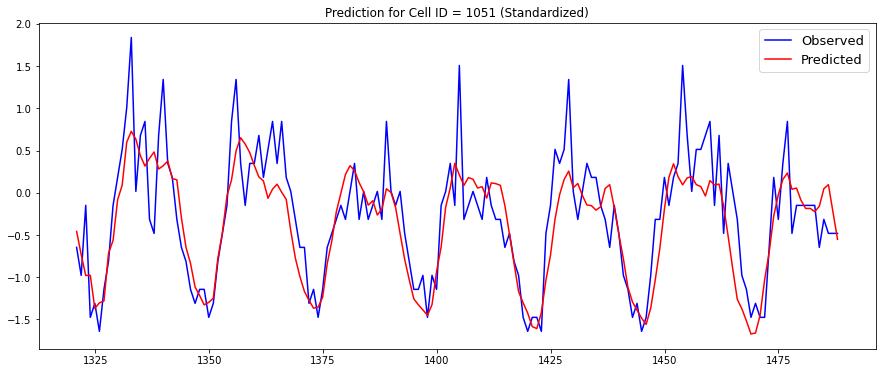

In [14]:
# Plotting the predictions
prediction_ID_1051 = np.array(prediction_ID_1051)

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d (Standardized)' % (Cell_ID[60])) 
plt.plot(hour[(train_size+validation_size):],Norm_TS_1051[(train_size+validation_size):],'b',label="Observed")
plt.plot(hour[(train_size+validation_size):], prediction_ID_1051,'r',label="Predicted")
plt.legend(loc='upper right',fontsize=13)


In [15]:
#---Non-standardized prediction
NN_prediction_ID_1051 = prediction_ID_1051*std_TS_1051+mean_TS_1051

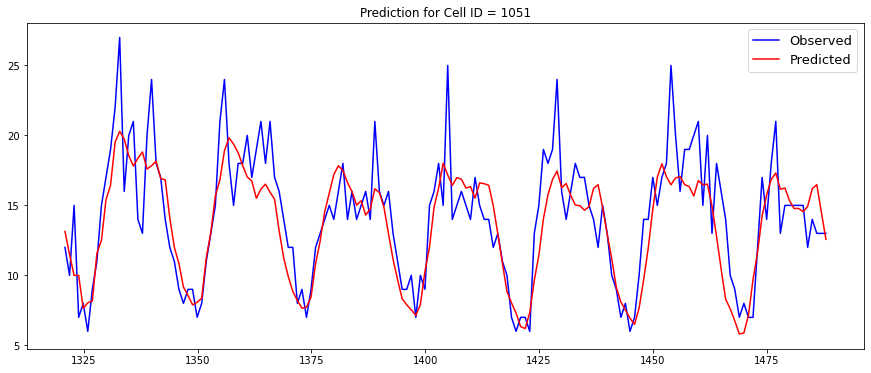

In [16]:
#---Plotting the predictions
prediction_ID_1051 = np.array(prediction_ID_1051)

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour[(train_size+validation_size):],TS_1051[(train_size+validation_size):],'b',label="Observed")
plt.plot(hour[(train_size+validation_size):], NN_prediction_ID_1051,'r',label="Predicted")
plt.legend(loc='upper right',fontsize=13)

In [17]:
#---Accuracy results

MAE = mean_absolute_error(NN_prediction_ID_1051,TS_1051[(train_size+validation_size):])
MSE = mean_squared_error(NN_prediction_ID_1051,TS_1051[(train_size+validation_size):])
print('MAE:', "%.3f" % MAE)
print('MSE:', "%.3f" % MSE)

MAE: 2.043
MSE: 6.944
